In [1]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
import pandas as pd
import glob
import keras
from deep_denoiser_model import Unet2D

In [2]:
model = Unet2D()

In [12]:
n = 6120
input = np.zeros((1,3,n))
real, imag = keras.ops.stft(input, 100, 24, 126)
print(real.shape)
model(input).shape

(1, 3, 256, 64)


ValueError: Exception encountered when calling DownsamplingLayer.call().

[1mInput 0 of layer "conv2d" is incompatible with the layer: expected axis 1 of input shape to have value 256, but received input with shape (1, 6, 256, 64)[0m

Arguments received by DownsamplingLayer.call():
  • x=tf.Tensor(shape=(1, 6, 256, 64), dtype=float32)

In [2]:
arr = np.array([[1,1], [2,2], [3,3]])
l = [7,8,9]

for a, b in zip(arr, l):
    print(a,b)

[1 1] 7
[2 2] 8
[3 3] 9


In [9]:
noise_files = glob.glob("../data/noise/train/**/*.npz", recursive=True)
for file in noise_files:
    arr = np.load(file, allow_pickle=True)
    if len(arr['noise_waveform_Z']) < 8000 or len(arr['noise_waveform_N']) < 8000 or len(arr['noise_waveform_E']) < 8000:
        print(file)

../data/noise/train\train\2022\noise_2022_054_180928_CH_EMBD.npz
../data/noise/train\train\2022\noise_2022_173_164545_CH_SFRA.npz
../data/noise/train\train\2022\noise_2022_186_153420_IV_MRGE.npz
../data/noise/train\train\2022\noise_2022_204_022430_OX_AGOR.npz
../data/noise/train\train\2023\noise_2023_039_095435_CH_SAUR.npz
../data/noise/train\train\2023\noise_2023_203_214007_CH_DAGMA.npz
../data/noise/train\train\2023\noise_2023_226_093939_CH_LAUCH.npz
../data/noise/train\train\2024\noise_2024_059_200835_CH_LAUCH.npz


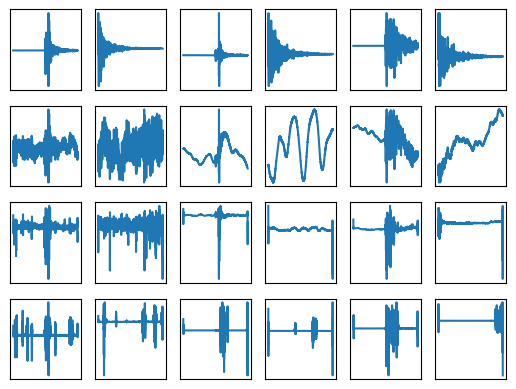

In [39]:
restored = np.load('../data/ColdDiffusion/Restored_direct_0.npy')
restored_sampling = np.load('../data/ColdDiffusion/Restored_sampling_0.npy')
original = np.load('../data/ColdDiffusion/Original.npy')
noise = np.load('../data/ColdDiffusion/Noised.npy')

n_samples = restored.shape[0]
fig, axs = plt.subplots(4,n_samples)

for i in range(n_samples):

    axs[0,i].plot(range(3000),original[i * 3000:3000 * (i+1)])
    #ax[0,i].set_title("Original eq event")
    axs[1,i].plot(range(3000),noise[3000 * i:3000 * (i+1)])
    #ax[1,i].set_title("Noisy eq")
    axs[2,i].plot(range(3000),restored[i,:])
    #ax[2,i].set_title("Denoised direct approach")
    axs[3,i].plot(range(3000),restored_sampling[i,:])
    #ax[3,i].set_title("Denoised sampling approach")

for row in axs:
    for ax in row:
        ax.set_xticks([])
        ax.set_yticks([])



In [4]:
dir_file = "C:/Users/cleme/ETH/Master/DataLab/dsl-as24-challenge-3/data/signal/signal_validation.pkl"
df = pd.read_pickle(dir_file)
df

In [8]:
cd_path = "C:/Users/cleme/ETH/Master/DataLab/dsl-as24-challenge-3/data/ColdDiffusion/df_test.csv"
cd_df = pd.read_pickle(cd_path)

In [3]:
cd_path = "C:/Users/cleme/ETH/Master/DataLab/dsl-as24-challenge-3/data/ColdDiffusion/df_noise_test.csv"
cd_df = pd.read_pickle(cd_path)

In [6]:
len(cd_df['E_channel'].iloc[0])

6000

In [6]:
dir_file = "C:/Users/cleme/ETH/Master/DataLab/dsl-as24-challenge-3/data/signal/train/train/2009/signal_2009_015_M20_D15_CH_MMK_HHE.npz"
signal = np.load(dir_file, allow_pickle=True)

dir_file_noise = "C:/Users/cleme/ETH/Master/DataLab/dsl-as24-challenge-3/data/noise/train/train/2022/noise_2022_003_000404_CH_SCRM.npz"
noise = np.load(dir_file_noise, allow_pickle=True)

noise

NpzFile 'C:/Users/cleme/ETH/Master/DataLab/dsl-as24-challenge-3/data/noise/train/train/2022/noise_2022_003_000404_CH_SCRM.npz' with keys: noise_waveform_Z, noise_waveform_N, noise_waveform_E, utc_start, station

In [ ]:
from scipy.signal import butter, filtfilt

time = range(6000)
fig, ax = plt.subplots(nrows = 1, ncols = 4)
s = signal["earthquake_waveform_Z"][3000:9000]
n = noise["noise_waveform_Z"][:6000]
y = s + n

def butter_bandpass(lowcut, highcut, fs, order=5):
    nyquist = 0.5 * fs  # Nyquist frequency
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return b, a

# Apply the filter
def apply_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = filtfilt(b, a, data)
    return y

# Set filter parameters
fs = 100

lowcut = 2.0  # Low cutoff frequency (Hz)
highcut = 20.0  # High cutoff frequency (Hz)
order = 4  # Order of the filter

# Apply the bandpass filter to the time series
denoised = apply_bandpass_filter(y, lowcut, highcut, fs, order)


ax[0].plot(time, s)
ax[1].plot(time,n )
ax[2].plot(time, s + n)
ax[3].plot(time, denoised)

In [ ]:
from scipy.signal import butter, filtfilt

# Bandpass filter design
def butter_bandpass(lowcut, highcut, fs, order=5):
    nyquist = 0.5 * fs  # Nyquist frequency
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return b, a

# Apply the filter
def apply_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = filtfilt(b, a, data)
    return y

# Set filter parameters
lowcut = 5.0  # Low cutoff frequency (Hz)
highcut = 30.0  # High cutoff frequency (Hz)
order = 4  # Order of the filter



Load and plot event/earthquake signal starting around sample 6000

---



In [ ]:
dir_file = "C:/Users/cleme/ETH/Master/DataLab/dsl-as24-challenge-3/data/signal/train/train/2009/signal_2009_009_M12_D17_CH_SENIN_HHN.npz"
#dir_file = "./examples/signal_2023_068_M11_D05_CH_DIX_HHZ.npz"


data_npz = np.load(dir_file, allow_pickle=True)
data = {key: data_npz[key] for key in data_npz}

fig = plt.figure(figsize=(8, 6))
gs = gridspec.GridSpec(3, 1, height_ratios=[1, 1, 1])  # Three rows, one column

# Create the subplots
ax1 = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1], sharex=ax1)
ax3 = fig.add_subplot(gs[2], sharex=ax1)

# Data for each plot
waveforms = ["earthquake_waveform_Z", "earthquake_waveform_N", "earthquake_waveform_E"]
axes = [ax1, ax2, ax3]

# Loop over axes to plot data and add common settings
for ax, waveform in zip(axes, waveforms):
    ax.plot(data[waveform], color="k")
    ax.set_xlim(0, 18000)
    ax.set_ylabel("Amplitude [m/s]")
    ax.axvline(x=6000, color='tab:red', linestyle='--', label="Earthquake signal start")
    ax.legend()

# Set x-label for the last axis
ax3.set_xlabel("Time [samples]")

ttl_str = "Magnitude " + str(data["magnitude"]) + " recorded in " + str(np.round(data["distance"],1))
ttl_str += " [km] at station " + str(data["code"][0]) + "." +str(data["code"][1]) + "." +str(data["code"][2][:2])
ax1.set_title(ttl_str)
# Display the plot
plt.tight_layout()
plt.show()

Load and plot noise sample


In [ ]:
dir_file = "./examples/noise_2023_003_033559_CH_SLE.npz"
#dir_file = "./examples/noise_2023_003_053339_CH_ZUR.npz"

data_npz = np.load(dir_file, allow_pickle=True)
data_noise = {key: data_npz[key] for key in data_npz}

fig = plt.figure(figsize=(8, 6))
gs = gridspec.GridSpec(3, 1, height_ratios=[1, 1, 1])  # Three rows, one column

# Create the subplots
ax1 = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1], sharex=ax1)
ax3 = fig.add_subplot(gs[2], sharex=ax1)

# Data for each plot
waveforms = ["noise_waveform_Z", "noise_waveform_N", "noise_waveform_E"]
axes = [ax1, ax2, ax3]

# Loop over axes to plot data and add common settings
for ax, waveform in zip(axes, waveforms):
    ax.plot(data_noise[waveform], color="k")
    ax.set_xlim(0, 8000)
    ax.set_ylabel("Amplitude [m/s]")

# Set x-label for the last axis
ax3.set_xlabel("Time [samples]")

ax1.set_title("Noise")
# Display the plot
plt.tight_layout()
plt.show()

Combine event and noise signal - vertical component

generate different combinations of event and noise signals by:
- shifting the start of the event signals in time
- changing the relative amplitude of event and noise signals - known as signal-to-nosie ratio (SNR)

In [ ]:
num_examples = 10
len_sample = 6000  # 6000 samples = 60 seconds
fig = plt.figure(figsize=(12, 10))
gs = gridspec.GridSpec(num_examples, 1)  # Three rows, one column

# generate noisy event waveforms 8event+noise) with simple variations
for i in range(num_examples):
    event = np.copy(data["earthquake_waveform_Z"])
    noise = np.copy(data_noise["noise_waveform_Z"])

    # randomly change relative amplitude of event and noise signal
    # relative amplitude = signal-to-noise ratio SNR
    # compute SNR
    signal_std = np.std(event[6000:6500])  # compute signals std over main event signal
    noise_std = np.std(noise[6000:6500])  #  compute nosie std 
    snr_original = signal_std / noise_std

    # change the SNR
    noise_snr_mod = noise * snr_original  # rescale noise so that SNR=1
    snr_random = np.random.uniform(0.5,2)  # random SNR     
    event_snr_mod = event * snr_random  # rescale event to desired SNR

    # randomly shift event start
    event_shift = np.random.randint(1000,6000)    
    
    noisy_event = event_snr_mod[event_shift:len_sample+event_shift] + noise_snr_mod[:len_sample]  # randomnly cut event waveform to shorter tiem window, cut noise waveform
    
    ax = fig.add_subplot(gs[i])
    ax.plot(noisy_event,color="k")
    ax.axvline(x=6000-event_shift, color='tab:red', linestyle='--', label="Earthquake signal start")
    ax.set_xlim(0,len_sample)
    ax.set_title("Shift: " + str(event_shift) + " /  SNR: " + str(np.round(snr_random,1)),y=0.6)



In [ ]:
import numpy as np
data = np.load('../data/DeepDenoiser/AZ_KNW_2012080816512091.npz')
data['data'].shape

In [ ]:
import matplotlib.pyplot as plt 

plt.plot([i for i in range(9001)],data['data'][:,0] / np.abs(np.max(data['data'][:,0] )))
plt.vlines(x=data['itp'], ymin = -1, ymax= 1, colors="red")